# Speech Enhancement

In [1]:
# carico la traccia audio 
import librosa 
wav_file = 'si658.wav'
data, sr = librosa.load(wav_file, sr=None)
print(data.shape)
print(sr)

(78644,)
16000


/home/gabriele/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


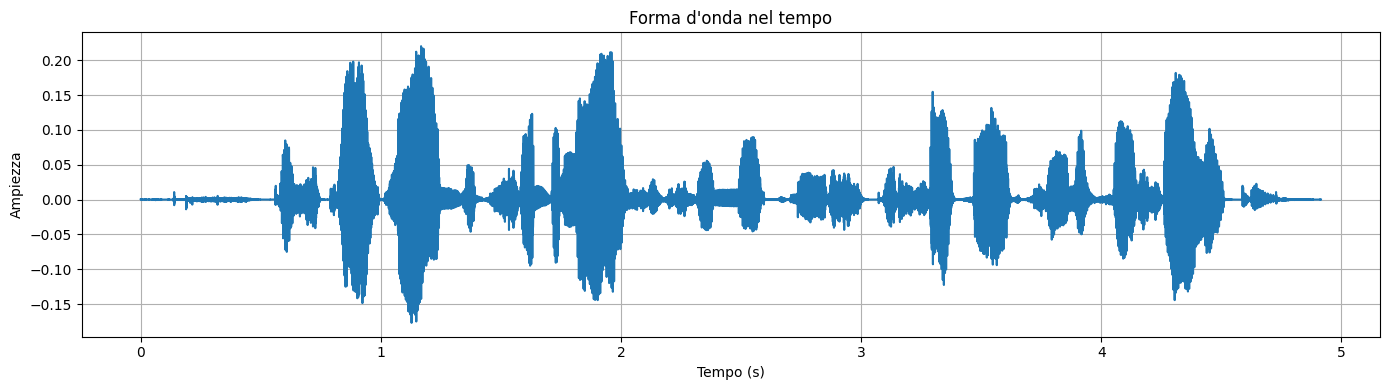

In [2]:
from matplotlib import pyplot as plt
import numpy as np 

# Crea l'asse temporale (in secondi)
time = np.linspace(0, len(data) / sr, num=len(data))
# Plotta la forma d'onda
plt.figure(figsize=(14, 4))
plt.plot(time, data)
plt.xlabel('Tempo (s)')
plt.ylabel('Ampiezza')
plt.title('Forma d\'onda nel tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
frame_size = 400
frame_hop = 200
window = np.hamming(frame_size)

frames = librosa.util.frame(data, frame_length=frame_size, hop_length=frame_hop)
# Applica la finestra Hamming a ciascun frame
windowed_frames = frames * window[:, np.newaxis]

print("Forma della matrice dei frame:", windowed_frames.shape)

Forma della matrice dei frame: (400, 392)


In [4]:
def WGN(signal, snr_db):
    E_s = np.sum(signal **2)
    noise = np.random.normal(0,1,size=len(signal))
    E_n = np.sum(noise **2)
    # scaling factor
    a = np.sqrt(10 ** (-snr_db / 20) * (E_s / E_n))
    return a * noise

In [61]:
snr_db = 30  # ad esempio 10 dB
noise = WGN(data, snr_db)
noisy_signal = data + noise

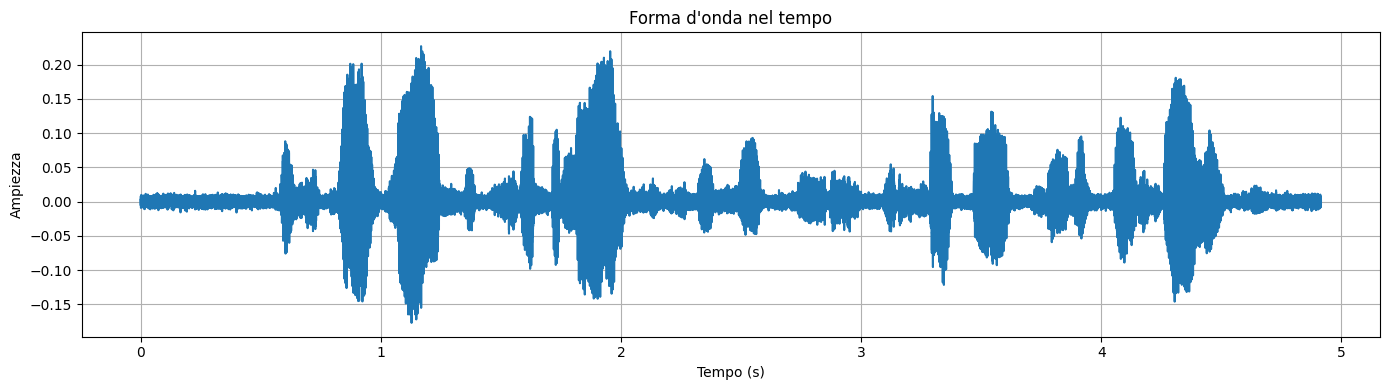

In [62]:
from matplotlib import pyplot as plt
import numpy as np 

# Crea l'asse temporale (in secondi)
time = np.linspace(0, len(data) / sr, num=len(data))
# Plotta la forma d'onda
plt.figure(figsize=(14, 4))
plt.plot(time, noisy_signal)
plt.xlabel('Tempo (s)')
plt.ylabel('Ampiezza')
plt.title('Forma d\'onda nel tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

Adesso devo analizzare il segnale frame per frame, andando quindi a sottrarre la componente rumorosa, supponendo che questo inizia sempre nei primi frames

In [63]:
# faccio comunque STFT
n_fft = 512
hop_length = 200
win_length = 400
window = 'hann'  # poi devo comunque ricostruire il segnale

In [76]:
S_noisy = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
magnitude = np.abs(S_noisy)
phase = np.angle(S_noisy)

# Stima spettro del rumore dai primi frames
num_noise_frames = 5
noise_spectrum = np.mean(magnitude[:, :num_noise_frames], axis=1, keepdims=True)

In [77]:
print(magnitude.shape)

(257, 394)


In [78]:
print(noise_spectrum.shape)

(257, 1)


In [79]:
# Spectral subtraction
magnitude_denoised = magnitude - noise_spectrum
magnitude_denoised = np.maximum(magnitude_denoised, 0)  # evita valori negativi

In [80]:
# Ricostruzione spettro completo con fase originale
S_denoised = magnitude_denoised * np.exp(1j * phase)

# ISTFT per ricostruire il segnale denoised
y_denoised = librosa.istft(S_denoised, hop_length=hop_length, win_length=win_length, window=window)

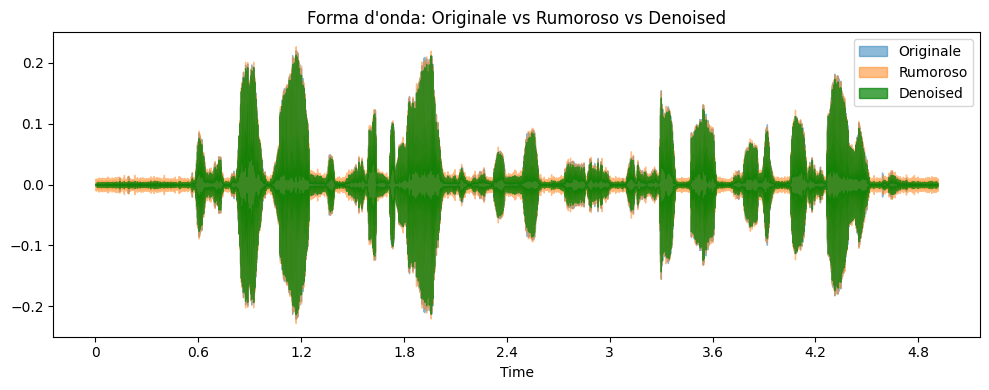

In [81]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.5, label='Originale')
librosa.display.waveshow(noisy_signal, sr=sr, alpha=0.5, label='Rumoroso')
librosa.display.waveshow(y_denoised, sr=sr, color='g', alpha=0.7, label='Denoised')
plt.legend()
plt.title('Forma d\'onda: Originale vs Rumoroso vs Denoised')
plt.tight_layout()
plt.show()

In [82]:
def compute_snr(clean, noisy):
    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]
    noise_part = noisy - clean
    snr = 10 * np.log10(np.sum(clean ** 2) / np.sum(noise_part ** 2))
    return snr

snr_before = compute_snr(data, noisy_signal) # prima di fare spectral substracting
print(snr_before)

snr_after = compute_snr(data, y_denoised) # dopo aver fatto spectral substracting
print(snr_after)

15.0
18.455259400862435


Più il denoising ha effetto, più effettivamente stiamo riducendo il rumore ed aumentando il ratio

In [83]:
# trasformate
S_clean = librosa.stft(data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
S_noisy = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)

# calcolo le magnitudo
mag_clean = np.abs(S_clean)
mag_noisy = np.abs(S_noisy)
phase = np.angle(S_noisy)
num_noise_frames = 5
noise_spectrum = np.mean(mag_noisy[:, :num_noise_frames], axis=1, keepdims=True)

# Spectral subtraction
mag_denoised = np.maximum(mag_noisy - noise_spectrum, 0)
S_denoised = mag_denoised * np.exp(1j * phase)

db_clean = librosa.amplitude_to_db(mag_clean, ref=np.max)
db_noisy = librosa.amplitude_to_db(mag_noisy, ref=np.max)
db_denoised = librosa.amplitude_to_db(mag_denoised, ref=np.max)

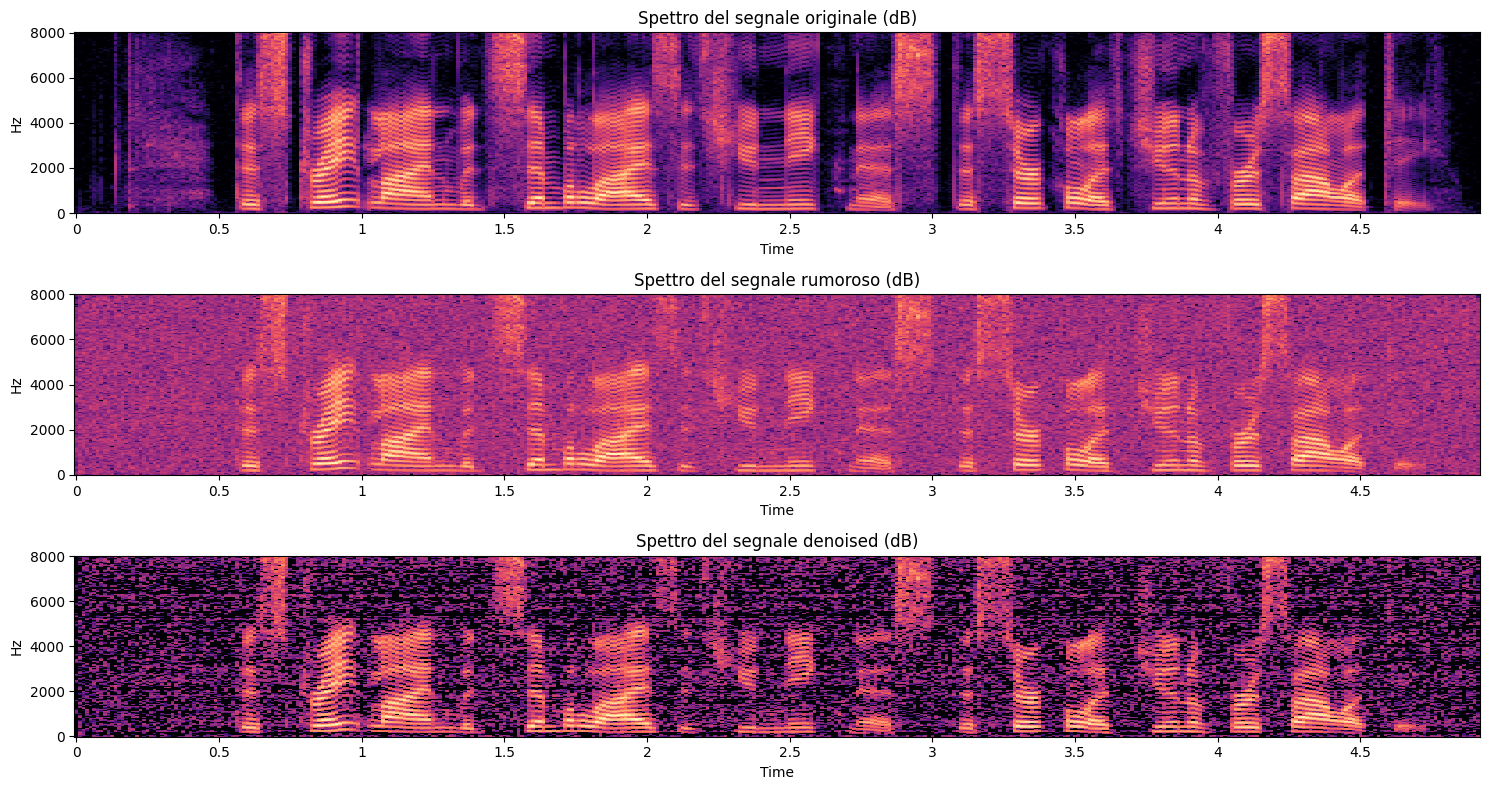

In [84]:
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(db_clean, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='magma')
plt.title("Spettro del segnale originale (dB)")
plt.subplot(3, 1, 2)
librosa.display.specshow(db_noisy, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='magma')
plt.title("Spettro del segnale rumoroso (dB)")
plt.subplot(3, 1, 3)
librosa.display.specshow(db_denoised, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='magma')
plt.title("Spettro del segnale denoised (dB)")
plt.tight_layout()
plt.show()


In [85]:
import IPython.display as ipd
ipd.Audio(y_denoised, rate=sr)

In [86]:
import soundfile as sf
sf.write('y_denoised.wav', y_denoised, sr)